# Continual Unlearning Results Visualization for CIFAR-100

This notebook analyzes and visualizes the performance of different continual unlearning methods on the CIFAR-100 dataset. We'll load results from CSV files and compare various methods against the ground truth (retrain_continual_unlearn).

In [9]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

In [10]:
# Load the data - assumes a similar format as CIFAR-10 but for CIFAR-100
try:
    df = pd.read_csv('eval_results_for_cifar100.csv')
    print(f"Loaded data with {df.shape[0]} rows and {df.shape[1]} columns")
except FileNotFoundError:
    print("Warning: eval_results_for_cifar100.csv not found. Please make sure the file exists.")
    # Create example dataframe structure for demonstration
    df = pd.DataFrame({
        'method': ['retrain', 'FT', 'NG', 'synaptag', 'GA'],
        'dataset': ['cifar100'] * 5,
        'forget_class_begin': [0] * 5,
        'forget_class_end': [10] * 5,
        'classes_forgotten': [10] * 5,
        'unlearning_time': [1000, 100, 150, 200, 50],
        'accuracy_retain': [90, 85, 87, 88, 70],
        'accuracy_forget': [5, 15, 10, 7, 20]
    })

# Filter out any methods we want to exclude
if 'method' in df.columns:
    df = df[~df['method'].isin(['boundary_expanding', 'boundary_shrink'])]

Loaded data with 152 rows and 215 columns


In [ ]:
# Function to calculate more precise accuracy metrics for CIFAR-100 dataset
def calculate_accurate_metrics(row):
    """Calculate precise metrics for forgotten, retained, and remembered classes for CIFAR-100"""
    try:
        forget_class_end = int(row['forget_class_end'])
        num_classes = 100  # CIFAR-100 has 100 classes
        
        # Handle both possibilities: train_accuracy_class or just accuracy_class columns
        train_prefix = 'train_accuracy_class_' if f'train_accuracy_class_{forget_class_end}' in row else 'accuracy_class_'
        test_prefix = 'test_accuracy_class_' if f'test_accuracy_class_{forget_class_end}' in row else None
        
        # Get accuracy of the end forget class
        # For the forget classes, check for 5 classes ending at forget_class_end
        forget_class_begin = int(row.get('forget_class_begin', forget_class_end - 4))
        forget_classes = [f'{train_prefix}{i}' for i in range(forget_class_begin, forget_class_end + 1) 
                          if f'{train_prefix}{i}' in row]
        
        if forget_classes:
            end_class_accuracy = np.mean([row[col] for col in forget_classes])
        else:
            end_class_accuracy = np.nan
            
        # Calculate retained accuracy (classes after forget_class_end)
        retained_classes = [f'{train_prefix}{i}' for i in range(forget_class_end + 1, num_classes) 
                           if f'{train_prefix}{i}' in row]
        retain_accuracy = np.mean([row[col] for col in retained_classes]) if retained_classes else np.nan
        
        # Calculate remembered accuracy (classes before forget_class_begin)
        remembered_classes = [f'{train_prefix}{i}' for i in range(0, forget_class_begin) 
                             if f'{train_prefix}{i}' in row]
        remember_accuracy = np.mean([row[col] for col in remembered_classes]) if remembered_classes else np.nan
        
        result = {
            'end_class_accuracy': end_class_accuracy,
            'precise_retain_accuracy': retain_accuracy,
            'precise_remember_accuracy': remember_accuracy
        }
        
        # If test accuracy columns exist, calculate those metrics too
        if test_prefix:
            forget_classes_test = [f'{test_prefix}{i}' for i in range(forget_class_begin, forget_class_end + 1) 
                                  if f'{test_prefix}{i}' in row]
            retained_classes_test = [f'{test_prefix}{i}' for i in range(forget_class_end + 1, num_classes) 
                                    if f'{test_prefix}{i}' in row]
            remembered_classes_test = [f'{test_prefix}{i}' for i in range(0, forget_class_begin) 
                                      if f'{test_prefix}{i}' in row]
            
            result.update({
                'end_class_accuracy_test': np.mean([row[col] for col in forget_classes_test]) if forget_classes_test else np.nan,
                'precise_retain_accuracy_test': np.mean([row[col] for col in retained_classes_test]) if retained_classes_test else np.nan,
                'precise_remember_accuracy_test': np.mean([row[col] for col in remembered_classes_test]) if remembered_classes_test else np.nan
            })
            
        return pd.Series(result)
    except (KeyError, ValueError) as e:
        print(f"Error processing row: {e}")
        return pd.Series({
            'end_class_accuracy': np.nan, 
            'precise_retain_accuracy': np.nan, 
            'precise_remember_accuracy': np.nan
        })

# Check if we have the necessary columns to calculate metrics
accuracy_class_cols = [col for col in df.columns if 'accuracy_class_' in col]
if accuracy_class_cols:
    # Apply the function to calculate the new metrics
    additional_metrics = df.apply(calculate_accurate_metrics, axis=1)
    df = pd.concat([df, additional_metrics], axis=1)
    
    # Display the dataframe with new metrics
    print("\nData with calculated metrics:")
    display(df[['method', 'forget_class_begin', 'forget_class_end', 'end_class_accuracy', 
              'precise_retain_accuracy', 'precise_remember_accuracy']].head(10))
else:
    print("\nAccuracy per class columns not found in the dataset. Cannot calculate precise metrics.")


Accuracy per class columns not found in the dataset. Cannot calculate precise metrics.


In [12]:
# Compare reported vs calculated metrics (if we have calculated metrics)
if 'precise_retain_accuracy' in df.columns and 'accuracy_retain' in df.columns:
    comparison_df = df[['method', 'forget_class_end', 'accuracy_retain', 'precise_retain_accuracy', 
                       'accuracy_forget', 'end_class_accuracy']].copy()
    
    # Calculate difference between reported and calculated metrics
    comparison_df['retain_diff'] = comparison_df['accuracy_retain'] - comparison_df['precise_retain_accuracy']
    comparison_df['forget_diff'] = comparison_df['accuracy_forget'] - comparison_df['end_class_accuracy']
    
    print("Average difference in retain accuracy:", comparison_df['retain_diff'].mean())
    print("Average difference in forget accuracy:", comparison_df['forget_diff'].mean())
    
    # Display comparison table
    display(comparison_df.head(10))
else:
    print("Skipping comparison - metrics not available")

Skipping comparison - metrics not available


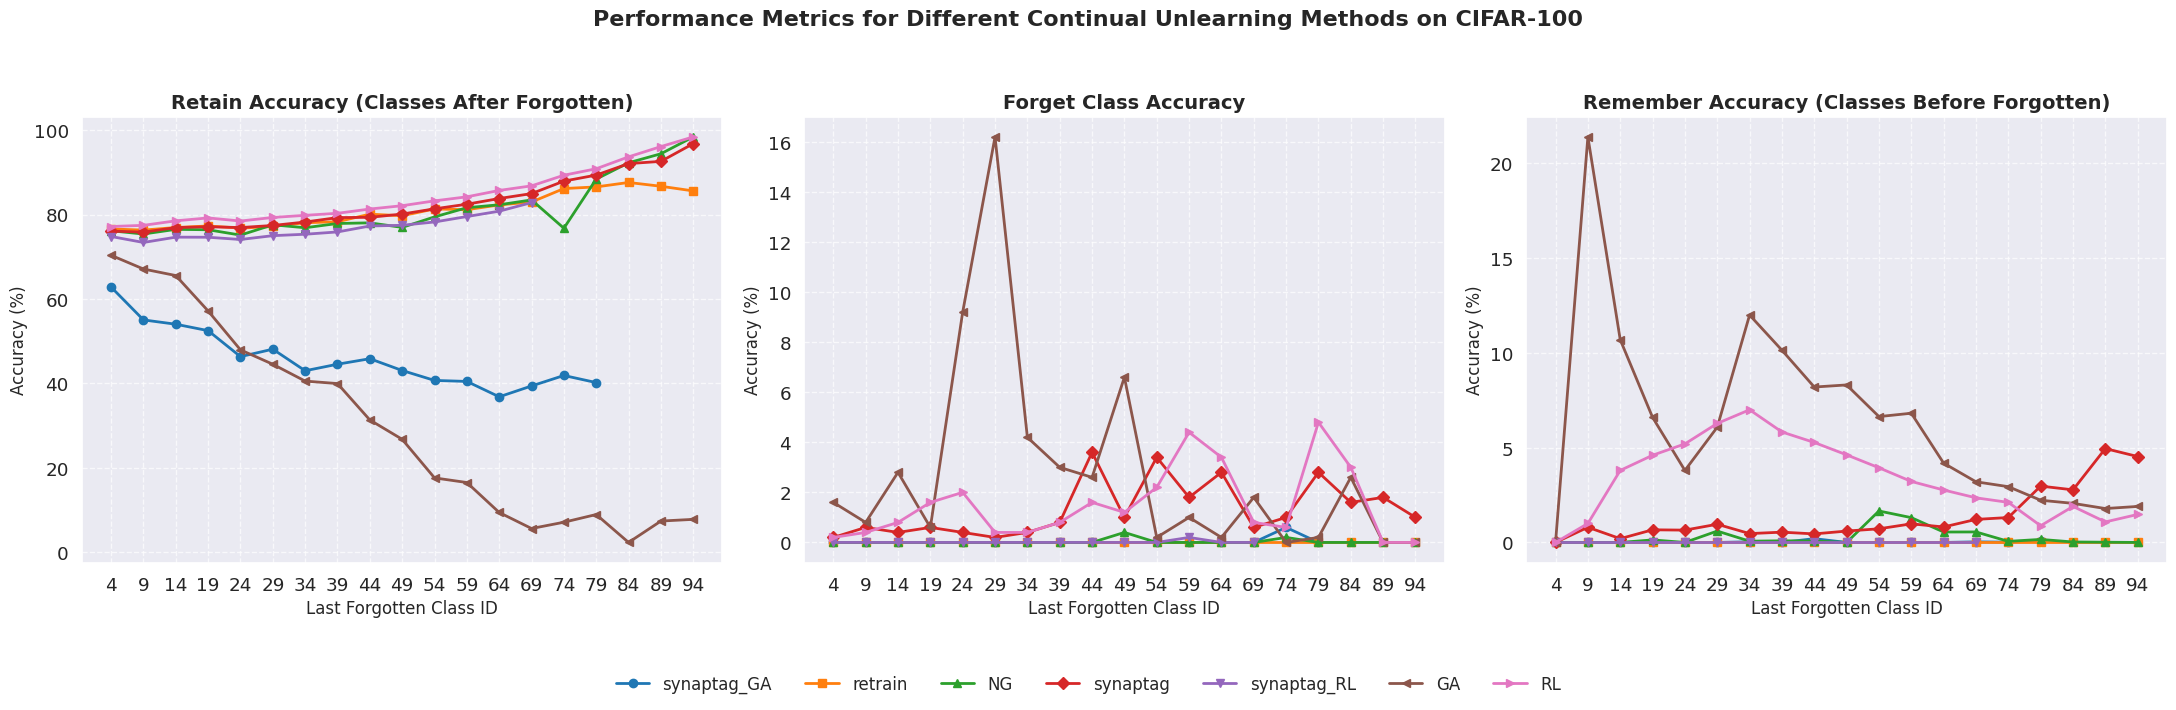

In [5]:
# Visualize the precise metrics for different methods (if we have enough data)
if 'precise_retain_accuracy' in df.columns and len(df['method'].unique()) > 1:
    # Get unique methods
    methods = df['method'].unique()
    methods = [method for method in methods if method != 'FT']
    colors = sns.color_palette("tab10", len(methods))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'X']
    
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(22, 7))
    
    for i, method in enumerate(methods):
        method_data = df[df['method'] == method].sort_values('forget_class_end')
        if len(method_data) == 0:
            continue
            
        # Plot retain accuracy
        axs[0].plot(method_data['forget_class_end'], method_data['precise_retain_accuracy'], 
                    marker=markers[i % len(markers)], label=method, color=colors[i], linewidth=2)
        
        # Plot forget class accuracy
        axs[1].plot(method_data['forget_class_end'], method_data['end_class_accuracy'], 
                    marker=markers[i % len(markers)], label=method, color=colors[i], linewidth=2)
        
        # Plot remember accuracy
        axs[2].plot(method_data['forget_class_end'], method_data['precise_remember_accuracy'], 
                    marker=markers[i % len(markers)], label=method, color=colors[i], linewidth=2)
    
    # Configure plots
    titles = ['Retain Accuracy (Classes After Forgotten)', 'Forget Class Accuracy', 'Remember Accuracy (Classes Before Forgotten)']
    ylabels = ['Accuracy (%)', 'Accuracy (%)', 'Accuracy (%)']
    
    for i in range(3):
        axs[i].set_title(titles[i], fontsize=14, fontweight='bold')
        axs[i].set_xlabel('Last Forgotten Class ID', fontsize=12)
        axs[i].set_ylabel(ylabels[i], fontsize=12)
        axs[i].grid(True, linestyle='--', alpha=0.7)
        # Dynamically set xticks based on data
        if 'forget_class_end' in df.columns:
            unique_classes = sorted(df['forget_class_end'].unique())
            if len(unique_classes) > 1:
                axs[i].set_xticks(unique_classes)
    
    # Add legend to the first subplot
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
              fancybox=True, shadow=True, ncol=len(methods), fontsize=12)
    
    plt.suptitle('Performance Metrics for Different Continual Unlearning Methods on CIFAR-100', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()
else:
    print("Not enough data to create visualization plots")

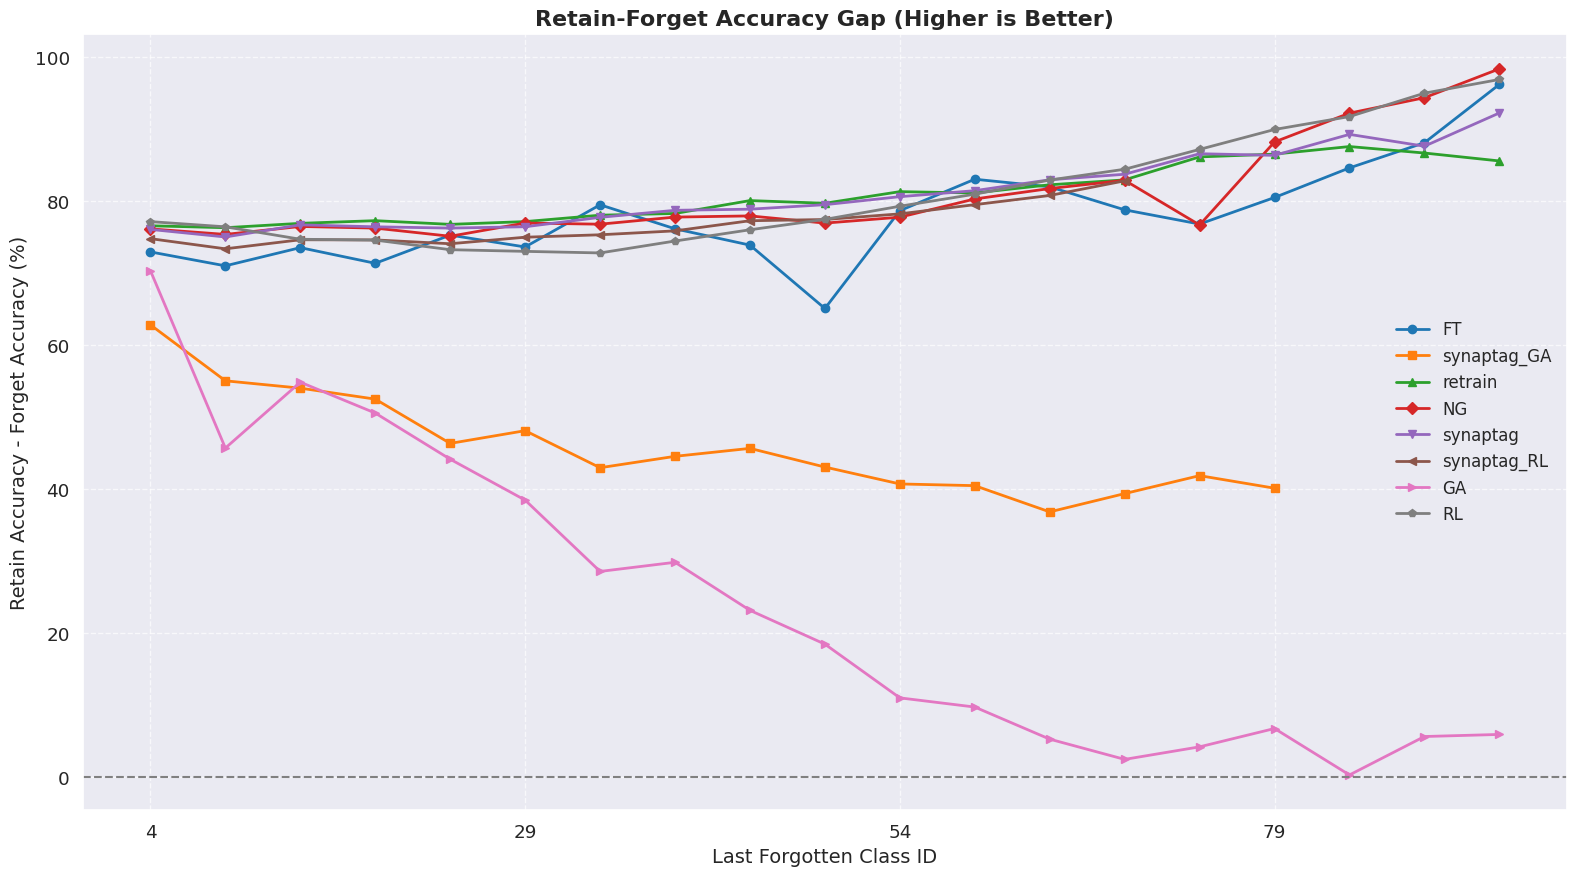

In [6]:
# Calculate and plot the Retain-Forget difference
if all(col in df.columns for col in ['end_class_accuracy', 'precise_retain_accuracy']):
    # Calculate the difference between retain accuracy and forget accuracy
    df['retain_forget_diff'] = df['precise_retain_accuracy'] - df['precise_remember_accuracy']
    
    # Get unique methods
    methods = df['method'].unique()
    colors = sns.color_palette("tab10", len(methods))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'X']
    
    # Create plot - higher values are better (high retain, low forget)
    plt.figure(figsize=(16, 9))
    
    for i, method in enumerate(methods):
        method_data = df[df['method'] == method].sort_values('forget_class_end')
        if len(method_data) == 0:
            continue
            
        plt.plot(method_data['forget_class_end'], method_data['retain_forget_diff'],
                 marker=markers[i % len(markers)], label=method, color=colors[i], linewidth=2)
    
    plt.title('Retain-Forget Accuracy Gap (Higher is Better)', fontsize=16, fontweight='bold')
    plt.xlabel('Last Forgotten Class ID', fontsize=14)
    plt.ylabel('Retain Accuracy - Forget Accuracy (%)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # Add a horizontal line at y=0 as a reference
    plt.axhline(y=0, color='grey', linestyle='--')
    
    # Dynamically set xticks based on data
    if 'forget_class_end' in df.columns:
        unique_classes = sorted(df['forget_class_end'].unique())
        if len(unique_classes) > 1:
            plt.xticks(unique_classes[::5])  # Show every 5th tick to avoid overcrowding
            
    plt.tight_layout()
    plt.show()
    

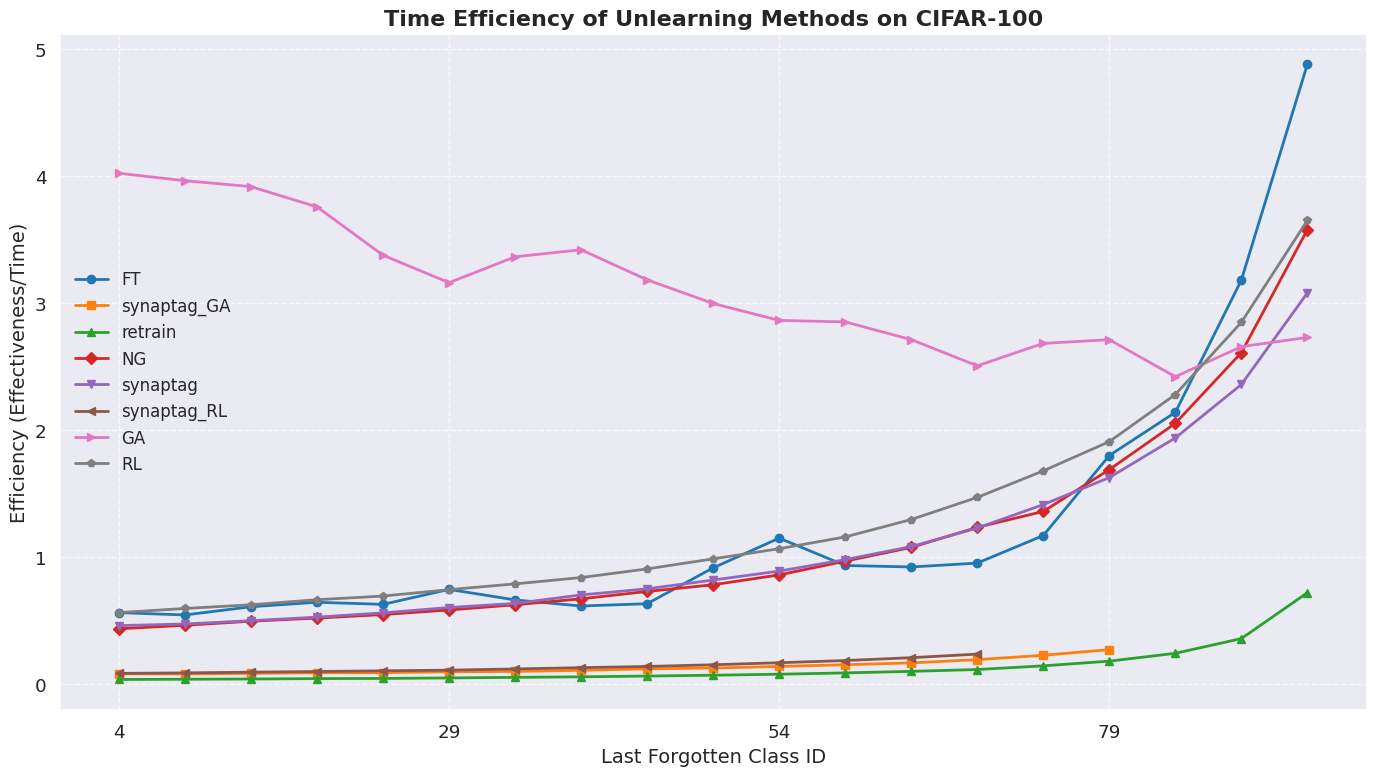

In [7]:
# Compute efficiency metrics: unlearning time vs performance (if we have sufficient data)
if all(col in df.columns for col in ['end_class_accuracy', 'precise_retain_accuracy', 'unlearning_time']):
    def calculate_efficiency(row):
        # Lower forget accuracy and higher retain accuracy is better
        forget_effectiveness = 100 - row['end_class_accuracy']  # Convert to "forgetfulness"
        retain_effectiveness = row['precise_retain_accuracy']
        
        # Overall effectiveness as a weighted combination
        overall_effectiveness = (forget_effectiveness + retain_effectiveness) / 2
        
        # Alternative effectiveness metric: retain-forget difference
        if 'retain_forget_diff' in row:
            alt_effectiveness = row['retain_forget_diff']  # Already calculated
        else:
            alt_effectiveness = row['precise_retain_accuracy'] - row['end_class_accuracy']
        
        # Efficiency = effectiveness / time
        efficiency = overall_effectiveness / (row['unlearning_time'] + 1e-10)  # Avoid division by zero
        alt_efficiency = (alt_effectiveness + 100) / (row['unlearning_time'] + 1e-10)  # Add 100 to make positive
        
        return pd.Series({
            'forget_effectiveness': forget_effectiveness,
            'retain_effectiveness': retain_effectiveness,
            'overall_effectiveness': overall_effectiveness,
            'alt_effectiveness': alt_effectiveness,
            'time_efficiency': efficiency,
            'alt_time_efficiency': alt_efficiency
        })
    
    # Apply efficiency calculation
    efficiency_metrics = df.apply(calculate_efficiency, axis=1)
    df = pd.concat([df, efficiency_metrics], axis=1)
    
    # Plot efficiency metric for each method
    plt.figure(figsize=(14, 8))
    
    methods = df['method'].unique()
    colors = sns.color_palette("tab10", len(methods))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'X']
    
    for i, method in enumerate(methods):
        method_data = df[df['method'] == method].sort_values('forget_class_end')
        if len(method_data) == 0:
            continue
            
        plt.plot(method_data['forget_class_end'], method_data['time_efficiency'],
                 marker=markers[i % len(markers)], label=method, color=colors[i], linewidth=2)
    
    plt.title('Time Efficiency of Unlearning Methods on CIFAR-100', fontsize=16, fontweight='bold')
    plt.xlabel('Last Forgotten Class ID', fontsize=14)
    plt.ylabel('Efficiency (Effectiveness/Time)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # Dynamically set xticks based on data
    if 'forget_class_end' in df.columns:
        unique_classes = sorted(df['forget_class_end'].unique())
        if len(unique_classes) > 1:
            plt.xticks(unique_classes[::5])  # Show every 5th tick to avoid overcrowding
            
    plt.tight_layout()
    plt.show()

In [8]:
# Create a summary table for a specific forget_class_end value
if all(col in df.columns for col in ['method', 'unlearning_time', 'end_class_accuracy', 'precise_retain_accuracy']):
    # Choose a middle point or the most common forget_class_end value
    if 'forget_class_end' in df.columns and len(df['forget_class_end'].unique()) > 0:
        # Get the most common or middle value for forget_class_end
        unique_values = sorted(df['forget_class_end'].unique())
        if len(unique_values) % 2 == 0:
            mid_value = unique_values[len(unique_values)//2 - 1]
        else:
            mid_value = unique_values[len(unique_values)//2]
            
        summary_df = df[df['forget_class_end'] == mid_value].copy()
        
        if len(summary_df) > 0:
            # Select and reorder columns for the summary
            summary_columns = ['method', 'unlearning_time', 'end_class_accuracy', 'precise_retain_accuracy', 
                               'precise_remember_accuracy', 'retain_forget_diff', 'overall_effectiveness', 'time_efficiency']
            summary_columns = [col for col in summary_columns if col in summary_df.columns]
            
            summary_df = summary_df[summary_columns].sort_values('retain_forget_diff', ascending=False)
            
            # Rename columns for better readability
            column_mapping = {
                'method': 'Method',
                'unlearning_time': 'Time (s)',
                'end_class_accuracy': 'Forget Accuracy',
                'precise_retain_accuracy': 'Retain Accuracy',
                'precise_remember_accuracy': 'Remember Accuracy',
                'retain_forget_diff': 'Retain-Forget Gap',
                'overall_effectiveness': 'Overall Effectiveness',
                'time_efficiency': 'Time Efficiency'
            }
            
            summary_df.columns = [column_mapping.get(col, col) for col in summary_df.columns]
            
            print(f"Summary table for forget_class_end = {mid_value} (sorted by Retain-Forget Gap):")
            display(summary_df)
        else:
            print(f"No data available for forget_class_end = {mid_value}")
    else:
        print("No forget_class_end values found in the dataset")
else:
    print("Missing columns required for summary table creation")

Summary table for forget_class_end = 49 (sorted by Retain-Forget Gap):


,Method,Time (s),Forget Accuracy,Retain Accuracy,Remember Accuracy,Retain-Forget Gap,Overall Effectiveness,Time Efficiency
44,retrain,1285.539839,0.0,79.72,0.000000,79.720000,89.86,0.069901
82,synaptag,109.325601,1.0,80.12,0.600000,79.520000,89.56,0.819204
134,RL,91.741789,1.2,82.10,4.622222,77.477778,90.45,0.985919
101,synaptag_RL,583.410962,0.0,77.46,0.000000,77.460000,88.73,0.152088
63,NG,112.897856,0.4,76.96,0.000000,76.960000,88.28,0.781946
9,FT,84.996281,11.2,66.74,1.644444,65.095556,77.77,0.914981
28,synaptag_GA,565.875928,0.0,43.06,0.000000,43.060000,71.53,0.126406
115,GA,20.051485,6.6,26.76,8.311111,18.448889,60.08,2.996287


## Conclusions

This notebook presents an analysis of different continual unlearning methods applied to the CIFAR-100 dataset. The key metrics evaluated include:

1. **Forget Accuracy**: How well the model forgets targeted classes (lower is better)
2. **Retain Accuracy**: How well the model maintains performance on classes it should remember (higher is better)
3. **Remember Accuracy**: How well the model keeps knowledge of earlier seen classes (higher is better)
4. **Retain-Forget Gap**: The difference between retain and forget accuracy (higher is better)
5. **Time Efficiency**: The effectiveness of the unlearning method relative to the computational time required

The Retain-Forget Gap is a particularly useful metric as it captures in a single number how well a method balances the trade-off between forgetting target classes and retaining knowledge of other classes. Methods with a high gap are successfully forgetting what they should while remembering what they should.

The analysis helps identify which methods provide the optimal balance between effective forgetting of specified classes while maintaining accuracy on retained classes, and which methods are most time-efficient.